# Tutorial B6 Manual CPA Attack

## The CPA Attack Theory

As a background on the CPA attack, please see the section [Correlation Power Analysis](https://wiki.newae.com/Correlation_Power_Analysis). It's also suggested that you complete Tutorial B1, since that will introduce Jupyter and show how to interface with ChipWhipserer using Python. It's assumed you've read that section and completed the tutorial and come back to this. Ok, you've done that? Good let's continue.

Assuming you **actually** read that, it should be apparent that there is a few things we need to accomplish:

1. Getting some power traces of our target while it's performing AES encryption.
1. Reading the data, which consists of the analog waveform (trace) and input text sent to the encryption core
1. Making the power leakage model, where it takes a known input text along with a guess of the key byte
1. Implementing the correlation equation, and then looping through all the traces
1. Ranking the output of the correlation equation to determine the most likely key.

This tutorial will deal with both recording power traces using ChipWhisperer and breaking them using a CPA attack.

## Capturing Power Traces

Capturing power traces will be very similar to previous tutorials, except this time we'll be using a loop to capture multiple traces, as well as numpy to store them. It's not necessary, but we'll also plot the trace we get using `matplotlib`.

### Setup

We'll use some helper scripts to make setup and programming easier. If you're using an XMEGA or STM (CWLITEARM) target, binaries with the correct should be setup for you:

In [1]:
%run "Helper Scripts/CWLite_Connect.ipynb"

In [2]:
%run "Helper Scripts/Setup_Target_Generic.ipynb"

In [3]:
# uncomment based on your target
#%run "Helper Scripts/Program_XMEGA.ipynb"
%run "Helper Scripts/Program_STM.ipynb"
#%run "Helper Scripts/No_Programmer.ipynb"
fw_path = "../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-cwlitearm.hex"

In [4]:
# program the target
program_target(scope, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to programming 6035 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6035 bytes


### Capturing Traces

Below you can see the capture loop. The main body of the loop loads some new plaintext, arms the scope, sends the key and plaintext, then finally records and appends our new trace to the `traces[]` list. At the end, we convert the trace data to numpy arrays, since that's what we'll be using for analysis.

In [5]:
#Capture Traces
from tqdm import tqdm
from chipwhisperer.capture.acq_patterns.basic import AcqKeyTextPattern_Basic
import numpy as np
import time

ktp = AcqKeyTextPattern_Basic(target=target)

from chipwhisperer.common.api.ProjectFormat import ProjectFormat

from chipwhisperer.common.api.TraceManager import TraceManager
from chipwhisperer.common.traces.TraceContainerNative import TraceContainerNative

project = ProjectFormat()
tm = project.traceManager()
tc = project.getTraceFormat()
#tc = TraceContainerNative()
project.setFilename("jupyter_test")

traces = []
textin = []
keys = []
N = 50  # Number of traces
target.init()
for i in tqdm(range(N), desc='Capturing traces'):
    # run aux stuff that should come before trace here

    key, text = ktp.newPair()  # manual creation of a key, text pair can be substituted here
    textin.append(text)
    keys.append(key)

    #target.reinit()

    target.setModeEncrypt()  # only does something for targets that support it
    target.loadEncryptionKey(key)
    target.loadInput(text)

    # run aux stuff that should run before the scope arms here

    scope.arm()

    # run aux stuff that should run after the scope arms here

    target.go()
    timeout = 50
    # wait for target to finish
    while target.isDone() is False and timeout:
        timeout -= 1
        time.sleep(0.01)

    try:
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition')
    except IOError as e:
        print('IOError: %s' % str(e))

    # run aux stuff that should happen after trace here
    _ = target.readOutput()  # clears the response from the serial port
    #traces.append(scope.getLastTrace())
    tc.addTrace(scope.getLastTrace(), text, "", key)

#Convert traces to numpy arrays
#trace_array = np.asarray(traces)  # if you prefer to work with numpy array for number crunching
#textin_array = np.asarray(textin)
#known_keys = np.asarray(keys)  # for fixed key, these keys are all the same


Capturing traces: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


In [6]:
tc._isloaded = True

If you want to save your traces for later analysis, here's how:
```python
now = datetime.now()
fmt_string = '{:02}{:02}_{}.npy'
trace_file_path = fmt_string.format(now.hour, now.minute, "traces")
textin_file_path = fmt_string.format(now.hour, now.minute, "textins")
keys_file_path = fmt_string.format(now.hour, now.minute, "keys")

print('Saving results to {},{} and {}...'.format(trace_file_path, textin_file_path, keys_file_path), end='')
# save to a files for later processing
np.save(trace_file_path, trace_array)
np.save(textin_file_path, textin_array)
np.save(keys_file_path, known_keys)
print('Done')
```

Finally, let's disconnect the scope and target since we're done with them.

In [7]:
from chipwhisperer.analyzer.preprocessing.pass_through import PassThrough
from chipwhisperer.analyzer.preprocessing.add_noise_random import AddNoiseRandom
ppmod = AddNoiseRandom(project.traceManager())
ppmod.noise = 0.05
ppmod.enabled = False

In [8]:
project.traceManager().appendSegment(tc)

In [9]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()

In [11]:
from chipwhisperer.analyzer.attacks.cpa import CPA
from chipwhisperer.analyzer.attacks.cpa_algorithms.progressive import CPAProgressive
from chipwhisperer.analyzer.attacks.models.AES128_8bit import AES128_8bit, SBox_output
from chipwhisperer.analyzer.preprocessing.add_noise_random import AddNoiseRandom


attack = CPA()
leak_model = AES128_8bit(SBox_output)
attack.setAnalysisAlgorithm(CPAProgressive, leak_model)
attack.setTraceSource(ppmod)
attack.setTraceStart(0)
attack.setTracesPerAttack(50)
attack.setIterations(1)
attack.setReportingInterval(10)
attack.setTargetSubkeys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
attack.setPointRange((0, -1))
stats = attack.processTracesNoGUI()



In [39]:
#attack.processTraces()
attack.attack.setModel(attack.attackModel)
attack.attack.getStatistics().clear()
attack.attack.setReportingInterval(attack.getReportingInterval())
attack.attack.setTargetSubkeys(attack.getTargetSubkeys())
#attack.attack.setStatsReadyCallback(self.sigAnalysisUpdated.emit)

for itNum in range(attack.getIterations()):
    startingTrace = attack.getTracesPerAttack() * itNum + attack.getTraceStart()
    endingTrace = startingTrace + attack.getTracesPerAttack() - 1

    # TODO:support start/end point different per byte
    attack.attack.addTraces(attack.getTraceSource(), (startingTrace, endingTrace), pointRange=attack.getPointRange(None))


In [40]:
stats = attack.attack.getStatistics()

In [71]:
maxes = stats.findMaximums()

In [15]:
for bnum in stats.findMaximums():
    print("Guess = 0x{:02X}, Corr = {}".format(bnum[0][0], bnum[0][2]))

Guess = 0x2B, Corr = 0.83802300191782
Guess = 0x7E, Corr = 0.8614444339480993
Guess = 0x15, Corr = 0.8887562310633897
Guess = 0x16, Corr = 0.8659980115480882
Guess = 0x28, Corr = 0.895355396747522
Guess = 0xAE, Corr = 0.9564161902659589
Guess = 0xD2, Corr = 0.8474116220134523
Guess = 0xA6, Corr = 0.8128553559811963
Guess = 0xAB, Corr = 0.8390390528506824
Guess = 0xF7, Corr = 0.9353027614692583
Guess = 0x15, Corr = 0.9189490651803272
Guess = 0x88, Corr = 0.8783745861199579
Guess = 0x09, Corr = 0.8932780616370999
Guess = 0xCF, Corr = 0.8834693892625843
Guess = 0x4F, Corr = 0.898461504581652
Guess = 0x3C, Corr = 0.9055434266587243


In [12]:
print(stats.findMaximums())

[array([( 43, 0, 0.86197935), ( 93, 0, 0.60420102), ( 37, 0, 0.59938012),
       (116, 0, 0.59757903), (216, 0, 0.5973248 ), ( 34, 0, 0.59203337),
       (245, 0, 0.58762431), ( 25, 0, 0.57876159), (118, 0, 0.57715407),
       (163, 0, 0.57536893), ( 64, 0, 0.57507588), (238, 0, 0.57298874),
       (101, 0, 0.5715158 ), (106, 0, 0.57089629), (251, 0, 0.56900944),
       (176, 0, 0.56797997), (120, 0, 0.56563879), ( 75, 0, 0.56338529),
       (157, 0, 0.56302478), ( 73, 0, 0.56184294), (248, 0, 0.55783421),
       ( 89, 0, 0.55758362), (100, 0, 0.55691042), (165, 0, 0.5569098 ),
       (193, 0, 0.5555085 ), ( 48, 0, 0.55503472), (152, 0, 0.55434285),
       ( 92, 0, 0.55382706), (218, 0, 0.55288139), (112, 0, 0.55235971),
       (195, 0, 0.55189391), ( 65, 0, 0.55002505), (105, 0, 0.54887364),
       (189, 0, 0.54826587), ( 63, 0, 0.54727997), ( 60, 0, 0.54483126),
       (229, 0, 0.54373438), (247, 0, 0.54350597), (110, 0, 0.54280027),
       (240, 0, 0.5416921 ), ( 38, 0, 0.53992765),

In [18]:
def num_perm(stats, key):
    return len(stats.diffs[key])

data = stats.maxes_list

maxdata = data[0]
tlist = []
for m in maxdata:
    tlist.append(m['trace'])
maxlist = np.zeros((num_perm(stats, 0), len(tlist)))
for i, m in enumerate(maxdata):
    for j in range(0, num_perm(stats, 0)):
        maxlist[m['maxes'][j][0], i] = m['maxes'][j][2]
        
newdata = maxlist
xrangelist = tlist



{'trace': 50, 'maxes': array([( 43, 0, 0.838023  ), (240, 0, 0.63614508), (220, 0, 0.63600515),
       (231, 0, 0.63565601), (106, 0, 0.62742928), (193, 0, 0.62037199),
       ( 53, 0, 0.61072652), (  5, 0, 0.61056498), (133, 0, 0.60047412),
       (124, 0, 0.59360042), (117, 0, 0.58971874), (142, 0, 0.58806372),
       (157, 0, 0.57444665), (112, 0, 0.57061842), ( 88, 0, 0.56860065),
       (171, 0, 0.56748794), ( 23, 0, 0.56713999), (244, 0, 0.5665296 ),
       (154, 0, 0.56463799), (  8, 0, 0.56353462), ( 14, 0, 0.56011765),
       ( 99, 0, 0.55973069), ( 28, 0, 0.55836105), (192, 0, 0.55403587),
       ( 91, 0, 0.55403217), ( 51, 0, 0.55100691), (164, 0, 0.54908925),
       (174, 0, 0.54891212), (184, 0, 0.5462953 ), (209, 0, 0.54599852),
       ( 18, 0, 0.54576103), (198, 0, 0.54569473), ( 70, 0, 0.54390762),
       (189, 0, 0.5434759 ), (  9, 0, 0.53965277), (104, 0, 0.53897389),
       (179, 0, 0.5381325 ), (175, 0, 0.53725411), ( 57, 0, 0.53698531),
       ( 75, 0, 0.5369254 ),

In [20]:
print(xrangelist)

[50]


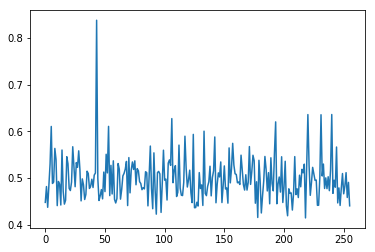

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(newdata)

In [14]:
print(keys[0][0])

43


In [17]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from chipwhisperer.common.results.outputvstime import OutputVsTimeNoGUI

data = stats.diffs
key = keys[0]

outvstime = OutputVsTimeNoGUI(stats, key)
ret = outvstime.getPlotData(1)
xrange = ret[0]
#if diffs is not None:
#    if not hasattr(diffs[0], '__iter__'):
#       diffs = [[t] for t in diffs]
#        
#    prange = getPrange(0, diffs)
#    xrangelist = prange
#import matplotlib.pyplot as plt
output_notebook()

p = figure()
#print(diffs[0])


p.line(xrange, ret[2], line_color='green')
p.line(xrange, ret[3], line_color='green')
#p.line(xrange, max2, line_color='red')
#p.line(xrange, min1, line_color='red')
#p.line(xrange, min2, line_color='red')
p.line(xrange, ret[1], line_color='red')
show(p)

Loading BokehJS ...

Loading BokehJS ...

<IPython.core.display.Javascript object>


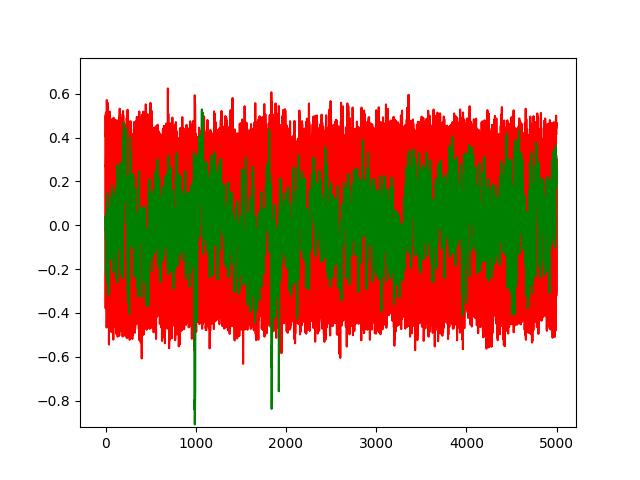

[-0.0219217   0.04289075 -0.00508801 ...  0.17649433  0.18264357
  0.24473179]
range(0, 5000)
[array([ 0.04973326,  0.11379771,  0.09539995, ...,  0.09182305,
        0.04732069, -0.0084342 ])]


In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt

data = stats.diffs

diffs = data[0]
#if diffs is not None:
#    if not hasattr(diffs[0], '__iter__'):
#       diffs = [[t] for t in diffs]
#        
#    prange = getPrange(0, diffs)
#    xrangelist = prange
#import matplotlib.pyplot as plt
output_notebook()

plt.figure()
#print(diffs[0])

traces = []
print(diffs[0x2B])
xrange = range(0, len(diffs[0]))
print(xrange)

print(diffs[0:1])

max1 = np.amax(diffs[0:(0x2B-1)], 0)
max2 = np.amax(diffs[0x2B + 1: -1], 0)
min1 = np.amin(diffs[0:(0x2B-1)], 0)
min2 = np.amin(diffs[0x2B + 1: -1], 0)

new_arr = np.zeros(len(diffs[0]))
for i in enumerate(max1):
    index = i[0]
    if abs(max1[index]) > abs(min1[index]):
        #print("max bigger: {} {}".format(max1[index], min1[index]))
        new_arr[index] = max1[index]
    else:
        #print("min bigger")
        new_arr[index] = min1[index]
        
new_arr2 = np.zeros(len(diffs[0]))
for i in enumerate(max2):
    index = i[0]
    if abs(max2[index]) > abs(min2[index]):
        #print("max bigger: {} {}".format(max1[index], min1[index]))
        new_arr2[index] = max2[index]
    else:
        #print("min bigger")
        new_arr2[index] = min2[index]

plt.plot(xrange, new_arr, 'r')
plt.plot(xrange, new_arr2, 'r')
#p.line(xrange, max2, line_color='red')
#p.line(xrange, min1, line_color='red')
#p.line(xrange, min2, line_color='red')
plt.plot(xrange, diffs[0x2B], 'g')

## Trace Analysis

### Using the Trace Data

Now that we have some traces, let's look at what we've actually recorded. Looking at the earlier parts of the script, we can see that the trace data is in `trace_array`, while `textin_array` stores what we sent to our target to be encrypted. For now, let's get some basic information (the total number of traces, as well as the number of sample points in each trace) about the traces, since we'll need that later:

In [ ]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

For the analysis, we'll need to loop over every byte in the key we want to attack, as well as every trace:
```python
for bnum in range(0, 16):
    for tnum in range(0, numtraces):
        pass
```
Though we didn't loop over them, note that each trace is made up of a bunch of sample points.
Let's take a closer look at AES so that we can replace that `pass` with some actual code.

### Calculating Correlation

Now that we have some power traces of our target that we can use, we can move on to the next steps of our attack. Looking way back to how AES works, remember we are effectively attemping to target the position at the bottom of this figure:

![title](https://wiki.newae.com/images/7/71/Sbox_cpa_detail.png)

The objective is thus to determine the output of the S-Box, where the S-Box is defined as follows:

In [ ]:
sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

Thus we need to write a function taking a single byte of input, a single byte of the guessed key, and return the output of the S-Box:

In [ ]:
def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

Finally, remember we want the Hamming Weight of the guess. Our assumption is that the system is leaking the Hamming Weight of the output of that S-Box. As a dumb solution, we could first convert every number to binary and count the 1's:

```python
>>> bin(0x1F)
'0b11111'
>>> bin(0x1F).count('1')
5
```
This will ultimately be fairly slow. Instead we make a lookup table using this idea:

In [ ]:
HW = [bin(n).count("1") for n in range(0, 256)]

### Performing the Check

Remember the objective is to calculate the following:
$$r_{i,j} = \frac{\sum_{d=1}^{D}[(h_{d,i} - \bar{h_i})(t_{d,j}-\bar{t_j})]}{\sqrt{\sum_{d=1}^D(h_{d,i}-\bar{h_i})^2\sum_{d=1}^D(t_{d,j}-\bar{t_j})^2}}$$

Where

| **Equation** | **Python Variable** | **Value**  | 
|--------------|---------------------|------------|
|  d           |       tnum          | trace number |
|  i           |       kguess        | subkey guess |
| j | j index trace point | sample point in trace |
| h | hypint | guess for power consumption | 
| t | traces | traces | 

It can be noticed there is effectively three sums, all sums are done over all traces. For this initial implementation we'll be explicitly calculating some of these sums, although it's faster to use NumPy to calculate across large arrays. We'll convert those three summations into variables, turning the equation into this format:

$$r_{i,j}=\frac{sumnum}{\sqrt{snumden1 * sumden2}}$$

Where:

$$sumnum = \sum_{d=1}^{D}[(h_{d,i} - \bar{h_i})(t_{d,j}-\bar{t_j})]$$

$$sumden1 = \sum_{d=1}^D(h_{d,i}-\bar{h_i})^2$$

$$sumden2 = \sum_{d=1}^D(t_{d,j}-\bar{t_j})^2$$

Looking at this, we can see that we'll need $\bar{h_i}$ and $\bar{t_j}$, so let's start by building some code that will give us those. Looking at the CPA tutorial, we can see that $h_{d,i}$ is just our guess for the power consumption in trace $d$ for subkey $i$. We can get that easily using the `HW` array and `intermediate()` function we defined earlier:

```python
for bnum in range(0, 16):
    cpaoutput = [0]*256
    maxcpa = [0]*256
    for kguess in range(0, 256):
        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]
```

Now we can get $\bar{h_i}$:
```python
meanh = np.mean(hyp, dtype=np.float64)
```

and $\bar{t_j}$ is just the mean of all of our traces:
```python
meant = np.mean(traces, axis=0, dtype=np.float64)
```

Next, let's move on to calculating the whole sums using $h_{d,i}$ and $t_{d,j}$ and the values we just calculated:

```python
#For each trace, do the following
for tnum in range(numtraces):
    hdiff = (hyp[tnum] - meanh)
    tdiff = traces[tnum,:] - meant

    sumnum = sumnum + (hdiff*tdiff)
    sumden1 = sumden1 + hdiff*hdiff 
    sumden2 = sumden2 + tdiff*tdiff
```

We can now get the correlation for each of our subkey guesses, which we'll call `cpaoutput[]`:

```python
cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
```

We're almost done! All that's left is to use that correlation to figure out which subkey best matches our power traces. First off, we only care about absolute value of the correlation (that there is a linear correlation), not sign. Additionally, though this didn't factor into our correlation calculation, remember that each trace was actually made up of a bunch of sample points. This means that what we actually have is the correlation of each subkey guess to each sample point. Typically only a few points in the trace are correlating, and it's the maximum across the entire trace we are concerned with, so we can pick our correlation for each subkey by:

```python
maxcpa[kguess] = max(abs(cpaoutput[kguess]))
```

Finally, we can find the subkey that best matches our data by finding the one with the biggest correlation:

```python
bestguess[bnum] = np.argmax(maxcpa)
```

Putting it all together:

#### Finished Script

In [ ]:
from __future__ import division, print_function

import numpy as np
from tqdm import tqdm

sbox = (
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

HW = [bin(n).count("1") for n in range(0, 256)]

numtraces = np.shape(trace_array)[0] #total number of traces
numpoint = np.shape(trace_array)[1] #samples per trace

pt = textin_array
traces = trace_array
knownkey = known_keys[0]
cparefs = [0] * 16
bestguess = [0]*16

for bnum in tqdm(range(0, 16), desc='Attacking subkeys'):
    cpaoutput = [0] * 256
    maxcpa = [0] * 256
    for kguess in range(0, 256):

        # Initialize arrays &amp; variables to zero
        sumnum = np.zeros(numpoint)
        sumden1 = np.zeros(numpoint)
        sumden2 = np.zeros(numpoint)

        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]

        # Mean of hypothesis
        meanh = np.mean(hyp, dtype=np.float64)

        # Mean of all points in trace
        meant = np.mean(traces, axis=0, dtype=np.float64)

        # For each trace, do the following
        for tnum in range(0, numtraces):
            hdiff = (hyp[tnum] - meanh)
            tdiff = traces[tnum, :] - meant

            sumnum = sumnum + (hdiff * tdiff)
            sumden1 = sumden1 + hdiff * hdiff
            sumden2 = sumden2 + tdiff * tdiff

        cpaoutput[kguess] = sumnum / np.sqrt(sumden1 * sumden2)
        maxcpa[kguess] = max(abs(cpaoutput[kguess]))

    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = np.argsort(maxcpa)[::-1]

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")

### Checking Our Guess

Since we were the ones who decided the key (and kept track of it in knownkey), we can check if our guess was right:

In [ ]:
for b in knownkey: print("%02x "%b, end="")
print("\n")
if (knownkey == bestguess).all():
    print("Guess was right")
else:
    print("Guess was wrong")

We can do even better by calculating the Partial Guessing Entropy.

The Partial Guessing Entropy (PGE) is a useful metric of where the correct answer is ranked. This requires us to know the actual encryption key used during operation, which we do know! 

Certain attacks will use different keys during the acqusition period, meaning the a list of all the known keys is required since there isn't a constant key. In our case, we already have access in `knownkey`.

Previously, we simply printed the maximum output for each subkey as follows:

```python
#Find maximum value of key
bestguess[bnum] = np.argmax(maxcpa)
```

To sort the list of CPA output's, we'll use the `argsort()` function from NumPy. This will output a list where the first element is the index of the lowest value, next element is the index of the next-highest element, etc. Because in our input list the `maxcpa` vector's indexes correspond to the key guess, this allows us to know where the keys are. We reverse that sorted list to put the first element as the maximum CPA output:

```python
cparefs = np.argsort(maxcpa)[::-1]
```

Finally, the Partial Guessing Entropy is simply the location of the known correct key byte inside that array. We can find that with the `.index()` function:

```python
print cparefs.index(0x2B)
```

Where the correct key should of course come from our `knownkey` variable instead of being hard-coded. Pulling it all together:

In [ ]:
pge = [0]*16
for bnum in range(0, 16):
    #Find maximum value of key
    #Find PGE
    pge[bnum] = list(cparefs[bnum]).index(knownkey[bnum])
    
print("PGE: ", end="")
for i in pge:
    print(i, end="")
print("")

### Improvements

The implementation of the correlation function runs as a loop over all traces. Ideally we'd like to implement this as a 'online' calculation; that is, we can add a trace in, observe the output, add another trace in, observe the output, etc. When generating plots of the Partial Guessing Entropy (PGE) vs. number of traces this is greatly preferred, since otherwise we need to run the loop many times!

We can use an alternate form of the correlation equation, which explicitly stores sums of the variables. This is easier to perform online calculation with, since when adding a new trace it's simple to update these sums. This form of the equation looks like:

$$r_{i,j} = \frac{D\sum_{d=1}^{D}h_{d,i}t_{d,j}-\sum_{d=1}^{D}h_{d,i}\sum_{d=1}^{D}t_{d,j}}{\sqrt{((\sum_{d=1}^Dh_{d,i})^2-D\sum_{d=1}^Dh_{d,i}^2)-((\sum_{d=1}^Dt_{d,j})^2-D\sum_{d=1}^Dh_{d,j}^2)}}$$